In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

import data
kd = data.Kaya_data

估计CI

In [16]:
# 已知数据
GDP = kd["GDP"]
MTCO2e = kd["MTCO2e"]

# 计算CI (排除无效数据)
CI_values = [mtco2e * 1000000 / gdp for gdp, mtco2e in zip(GDP, MTCO2e) if gdp != -1 and mtco2e != -1]

# 计算均值和标准差
mean_CI = np.mean(CI_values)
std_CI = np.std(CI_values, ddof=1)  # 使用样本标准差

# 计算95%的置信区间
n = len(CI_values)
alpha = 0.05  # 95%置信区间
t_score = stats.t.ppf(1 - alpha / 2, df=n - 1)  # t分布临界值
margin_of_error = t_score * (std_CI / np.sqrt(n))

# 置信区间
CI_lower = mean_CI - margin_of_error
CI_upper = mean_CI + margin_of_error

mean_CI, CI_lower, CI_upper

(148.20508583451706, 143.02943666164063, 153.3807350073935)

In [17]:
# 经验公式算出每年的旅游收入
tourism_income = kd["Tourism_Numbers"]
tourism_income = [i * 632 for i in tourism_income]
# print(tourism_income)

[0.24054792545672665, 0.2550921443464736, 0.26316286083973517, 0.2697980847037535, 0.29481817238606595, 0.34185720468763914, 0.34724319599486536, 0.31661609682139635, 0.30430147277252234, 0.44206299975749025]


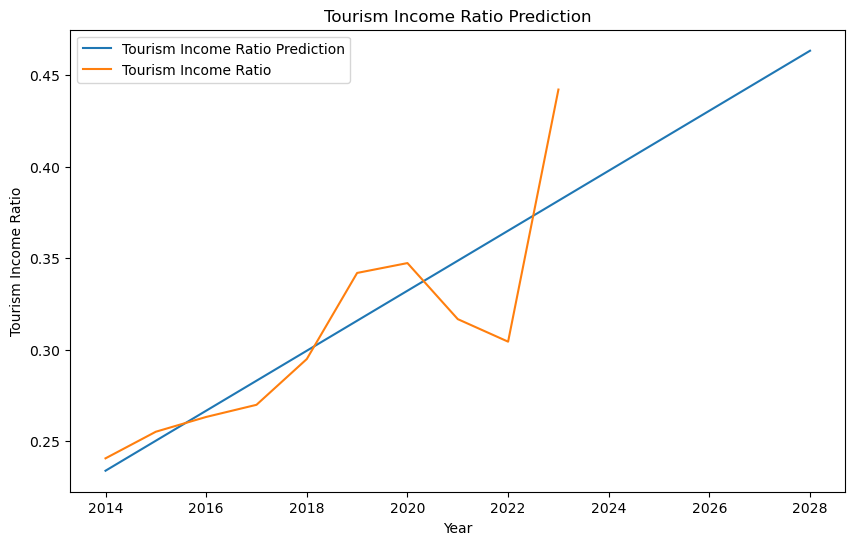

In [18]:
# 旅游收入占GDP的比例
tourism_income_ratio = [i / j for i, j in zip(tourism_income, GDP) if j != -1]
print(tourism_income_ratio)

# 线性预测后面的比例
X = np.arange(2014, 2024).reshape(-1, 1)
y = np.array(tourism_income_ratio).reshape(-1, 1)
assert len(X) == len(y)

lr_model = LinearRegression()
lr_model.fit(X, y)

X = np.arange(2014, 2029).reshape(-1, 1)
tourism_income_ratio_pred = lr_model.predict(X)

# 旅游收入预测
# 画图
plt.figure(figsize=(10, 6))
plt.plot(X, tourism_income_ratio_pred, label="Tourism Income Ratio Prediction")
plt.plot(np.arange(2014, 2024), tourism_income_ratio, label="Tourism Income Ratio")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Tourism Income Ratio")
plt.title("Tourism Income Ratio Prediction")
plt.show()


In [25]:
# 预测旅游的CI：用总的CI乘以预测的旅游收入比例
CI_pred = [mean_CI * i for i in tourism_income_ratio_pred]

CI_pred = [float(ci) for ci in CI_pred]
CI_pred

C:\Users\19912\AppData\Local\Temp\ipykernel_26160\1620357659.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  CI_pred = [float(ci) for ci in CI_pred]


[34.648027899075004,
 37.07746091852243,
 39.506893937969856,
 41.93632695741728,
 44.3657599768647,
 46.795192996312124,
 49.224626015759554,
 51.65405903520698,
 54.0834920546544,
 56.51292507410182,
 58.94235809354925,
 61.371791112996675,
 63.8012241324441,
 66.23065715189152,
 68.66009017133895]

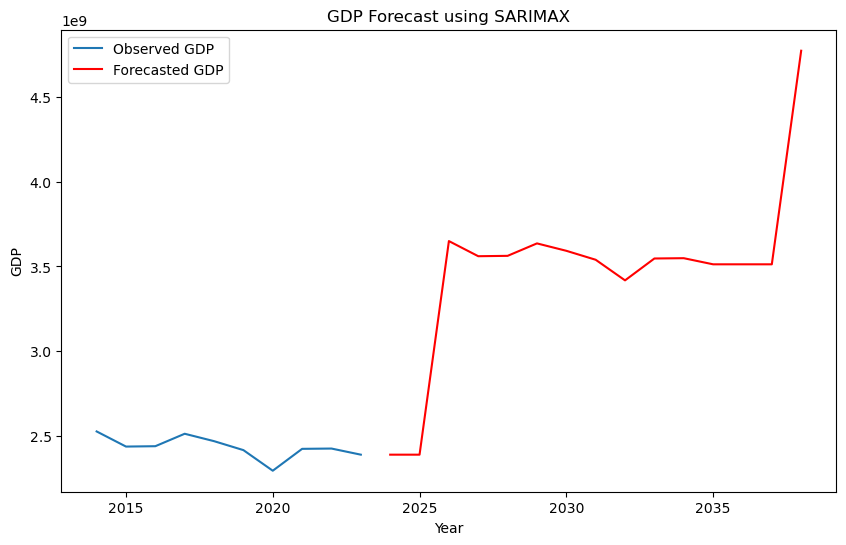

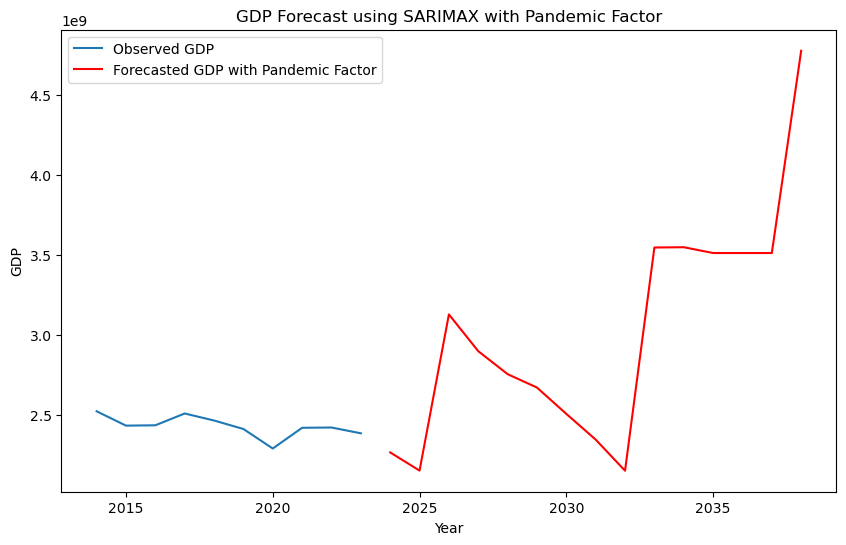

In [15]:
# 提取GDP数据并去除无效数据
GDP_valid = [gdp for gdp in GDP if gdp != -1]

# 使用SARIMAX模型进行预测
model = SARIMAX(GDP_valid, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# 预测未来15年的GDP
forecast = results.get_forecast(steps=15)
forecast_mean = forecast.predicted_mean

# 画图
plt.figure(figsize=(10, 6))
plt.plot(range(2014, 2014 + len(GDP_valid)), GDP_valid, label='Observed GDP')
plt.plot(range(2014 + len(GDP_valid), 2014 + len(GDP_valid) + 15), forecast_mean, label='Forecasted GDP', color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Forecast using SARIMAX')
plt.show()

# 加入疫情因子
# 假设疫情因子对GDP的影响从2020年开始，每年减少5%
pandemic_factor = 0.95
for i in range(2020, 2029):
    forecast_mean[i - 2020] *= pandemic_factor
    pandemic_factor *= 0.95

# 画图
plt.figure(figsize=(10, 6))
plt.plot(range(2014, 2014 + len(GDP_valid)), GDP_valid, label='Observed GDP')
plt.plot(range(2014 + len(GDP_valid), 2014 + len(GDP_valid) + 15), forecast_mean, label='Forecasted GDP with Pandemic Factor', color='red')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Forecast using SARIMAX with Pandemic Factor')
plt.show()